In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw1.ok')

Assignment: hw1
OK, version v1.14.11



# Homework 1 - INT 15

In [2]:
![election_prediction](http://donsnotes.com/politics/images/clinton-trump-rating.png)

/bin/sh: -c: line 0: syntax error near unexpected token `http://donsnotes.com/politics/images/clinton-trump-rating.png'
/bin/sh: -c: line 0: `[election_prediction](http://donsnotes.com/politics/images/clinton-trump-rating.png)'


We haven't yet talked about predictive models in class yet, but we can at least think about what makes a "good" prediction.  In this assignment, we'll focus on evaluating the quality of election predictions made by the website [fivethirtyeight.com](https://www.fivethirtyeight.com).  As one prominent example, fivethirtyeight predicted that Clinton had a 70.9% chance to win the election.  Was their model wrong?

To gain insight into questions like this, we'll focus on  [US House elections predictions from 2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/).  Their predictions are based predominantly on polling data but include other sources as well (state of the economy, overall favoriability of politic parties, etc).  

This homework is based loosely on [this article](https://projects.fivethirtyeight.com/checking-our-work/).  Please read the article before beginning the assignment.


In [3]:
!wget https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/us_house_elections.csv

--2019-05-21 23:00:16--  https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/us_house_elections.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.196.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24027649 (23M) [text/plain]
Saving to: ‘us_house_elections.csv.5’

us_house_elections. 100%[===================>]  22.91M  4.13MB/s    in 9.9s    

2019-05-21 23:00:26 (2.32 MB/s) - ‘us_house_elections.csv.5’ saved [24027649/24027649]



`ls` command can be used to verify that the file is now listed in our folder.   

In [4]:
import pandas as pd ## call pandas functions using "pd"
import numpy as np  ## call numpy functions using "np"
election_data = pd.read_csv("us_house_elections.csv")

/Users/Eduardo/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
!ls -F -l

total 294344
-rw-r--r--   1 Eduardo  staff    218704 May 21 22:58 alvinbui@ucsb.edu_hw01.ipynb
-rw-r--r--   1 Eduardo  staff    117678 May 21 22:59 amandaho@ucsb.edu_hw01.ipynb
-rw-r--r--   1 Eduardo  staff    227318 May 21 22:59 andrew_hong@ucsb.edu_hw01.ipynb
-rw-r--r--   1 Eduardo  staff    111255 May 21 22:59 aschoettler@ucsb.edu_hw01.ipynb
-rw-r--r--   1 Eduardo  staff    102094 May 21 23:00 chautran@ucsb.edu_hw01.ipynb
-rw-r--r--   1 Eduardo  staff    176948 May 21 22:58 h_lin@ucsb.edu_hw01.ipynb
-rw-r--r--   1 Eduardo  staff       250 May 21 22:58 hw01.ok
-rw-r--r--   1 Eduardo  staff       162 May 21 22:58 hw1.ok
-rw-r--r--@  1 Eduardo  staff    562029 May 21 22:58 mlb_games.csv
-rw-r--r--@  1 Eduardo  staff    562029 May 21 22:59 mlb_games.csv.1
-rw-r--r--@  1 Eduardo  staff    562029 May 21 23:00 mlb_games.csv.2
drwxr-xr-x  11 Eduardo  staff       352 May 21 22:58 tests/
-rw-r--r--@  1 Eduardo  staff  24027649 May 21 22:58 us_house_elections.csv
-rw-r--r--@  1 Eduardo  staff 

## Examining the Data

Display the first 10 rows of the dataset using `iloc`.

Fivethirtyeight has three different prediction models: `lite`, `classic` and `deluxe`, which roughly incorporate an increasing number of assumptions.  In this assignment lets focus on evaluting the quality of the `classic` predictions.  You can read more about how the prediction models work [here](https://fivethirtyeight.com/methodology/how-fivethirtyeights-house-and-senate-models-work/).

Fivethirtyeight continuously updated their predictions as more polling data became available for each of the races.  Let's focus on the predictions a few months before the election, on August 11th, and on the morning of election day, November 6th.  

### Question 1

Create a new pandas dataframe called `election_sub` by filtering to include only rows in which the `forecast_type` is "classic", and the date of the foreceast (`forecast_date`) is 8/11 or 11/6.

<!--
BEGIN QUESTION
name: q1
manual: false
points: 2
-->

In [6]:
#election_data['forecast_date'] = pd.to_datetime(election_data['forecast_date'])


In [7]:
#election_sub = election_data.loc[election_data['forecast_type']=='classic']
#election_sub['forecast_date'].dt.date.astype(str)

In [8]:
election_sub = election_data[((election_data.forecast_type=="classic") & (election_data.forecast_date=="2018-08-11")) | ((election_data.forecast_type=="classic")&(election_data.forecast_date=="2018-11-06"))]

In [9]:
election_sub.count()

year                   1930
office                 1930
state                  1930
district               1928
special                1928
election_date          1930
forecast_date          1930
forecast_type          1930
party                  1930
candidate              1928
projected_voteshare    1928
actual_voteshare          0
probwin                1930
probwin_outcome        1930
dtype: int64

In [10]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 2

We want to check whether events predicted by 538 to occur with probability _close to_ X% actually occured about X% of the time.  To do this, we have to define _close_.  First, we'll define the `cut_points` as 20 equally spaced numbers between 0 and 1 using `np.linspace`.  Then we'll group the predicted probabilities into the `19` equally spaced bins determined by those cut points.  Define the bin for each observation using the `pd.cut` function on the `probwin` variable.  We'll assign the result to a new column of `election_sub` called `bin`.

<!--
BEGIN QUESTION
name: q2
manual: false
points: 2
-->

In [11]:
cut_points = np.linspace(0, 1, 20)

election_sub['bin'] =pd.cut(election_sub['probwin'], bins=cut_points)
election_sub

/Users/Eduardo/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,year,office,state,district,special,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome,bin
4,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,D,Greg Hunter,31.332930,NaN,0.00032,0,"(0.0, 0.0526]"
5,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,R,Liz Cheney,63.153790,NaN,0.99968,1,"(0.947, 1.0]"
10,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,D,Richard Neece Ojeda,44.295840,NaN,0.07366,0,"(0.0526, 0.105]"
11,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,R,Carol Devine Miller,55.704160,NaN,0.92634,1,"(0.895, 0.947]"
18,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,D,Talley Sergent,43.099960,NaN,0.06562,0,"(0.0526, 0.105]"
19,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,I,Daniel Lutz Jr.,3.207378,NaN,0.00000,0,NaN
20,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,R,Alex X. Mooney,53.692660,NaN,0.93438,1,"(0.895, 0.947]"
25,2018,House,WV,1.0,False,2018-11-06,2018-11-06,classic,D,Kendra Fershee,37.357480,NaN,0.00042,0,"(0.0, 0.0526]"
26,2018,House,WV,1.0,False,2018-11-06,2018-11-06,classic,R,David B. McKinley,62.642520,NaN,0.99958,1,"(0.947, 1.0]"
31,2018,House,WI,8.0,False,2018-11-06,2018-11-06,classic,D,Beau Liegeois,39.092470,NaN,0.00468,0,"(0.0, 0.0526]"


In [12]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 3

Now we've grouped the observations into a discrete set of bins according to the predicted probability, `probwin`.  Within each bin, we now want to compute the actual fraction of times the candidates won. If 538 did a good job, it will be close to the predited probabilities.   You'll need to use the `groupby` function to compute the mean of `probwin_outcome` (1 is a win and 0 is a loss) within each bin.  Save the fraction of actual wins in each bin in a list called `fraction_outcome`.

<!--
BEGIN QUESTION
name: q3
manual: false
points: 2
-->

In [13]:
fraction_outcome = election_sub.groupby("bin").apply(np.mean)["probwin_outcome"]
fraction_outcome=fraction_outcome.tolist()
fraction_outcome

[0.0017152658662092624,
 0.0625,
 0.023255813953488372,
 0.14285714285714285,
 0.2,
 0.058823529411764705,
 0.23529411764705882,
 0.2727272727272727,
 0.4666666666666667,
 0.5,
 0.5333333333333333,
 0.7272727272727273,
 0.7647058823529411,
 0.9411764705882353,
 0.8,
 0.8571428571428571,
 0.9767441860465116,
 0.9375,
 0.9984779299847792]

In [14]:
ok.grade("q3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4

For this problem we'll make a plot of the predicted probabilities and actual fraction of wins in each bin.  We've already computed the actual fraction of wins; all that remains is to plot it against the predicted value assocaited with each bin.  For the predicted value in each bin, we'll use the midpoint of the bin.  Compute the midpoints of each bin from `cut_points`.

<!--
BEGIN QUESTION
name: q4
manual: false
points: 2
-->

In [15]:
cut_points 
midpoints=[]
for i in range (0,19):
    midpoints.append((cut_points[i]+cut_points[i+1])/2)
midpoints
    
    


[0.02631578947368421,
 0.07894736842105263,
 0.13157894736842105,
 0.18421052631578946,
 0.23684210526315788,
 0.2894736842105263,
 0.3421052631578947,
 0.39473684210526316,
 0.4473684210526315,
 0.5,
 0.5526315789473684,
 0.6052631578947368,
 0.6578947368421052,
 0.7105263157894737,
 0.763157894736842,
 0.8157894736842105,
 0.8684210526315789,
 0.9210526315789473,
 0.9736842105263157]

In [16]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Now make a scatterplot using `midpoints` as the x variable and `fraction_outcome` as the y variable.  Draw a dashed line from `[0,0]` to `[1,1]` to mark the line y=x.  

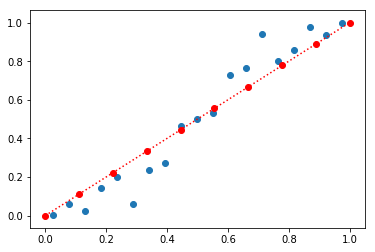

Ellipsis

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
x = midpoints
y = fraction_outcome


plt.scatter(x, y)
plt.plot(np.linspace(0, 1, 10),np.linspace(0, 1, 10), c= "red", marker='o', linestyle=':')
plt.show()

...

### Question 5: adding error bars

If you did things correctly, it should look like fivethirtyeight has done "pretty" well with their forecasts: the actual fraction of wins tracks closely with the predicted number.  But how do we decide what's "good enough"? Consider this example: I correctly predict that a coin is fair (e.g. that it has a 50% chance of heads, 50% chance of tails).  But if I flip it 100 times, I can be pretty sure it won't come up heads exactly 50 times.  The fact that it didn't come up heads exactly 50 times doesn't make my prediction incorrect.

To assess how reasonable the predictions are, I need to quantify the uncertainty in my estimate.  It's reasonable to assume that within each bin, $k$, the observed number of wins, $Y_k \sim Bin(n_k, p_k)$, where $n_k$ is the number of elections and $p_k$ is the predicted win probability in bin $k$.

Classical results tell us that the obseved fraction of wins in bin $k$, $\hat p = \frac{Y_k}{n_k}$ has variance Var$\left(\hat p_k\right) = \frac{p_k (1-p_k)}{n_k} \approx \frac{\hat p_k(1- \hat p_k)}{n_k}$.  The standard deviation of the Binomial proportion then is $\hat \sigma_k \approx \sqrt{\frac{\hat p_k(1- \hat p_k)}{n_k}}$.  

If we use the [normal approximation to generate a confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval), then the 95% interval has the form $\hat p_k \pm 1.96 \hat \sigma_k$.


Create a new "aggregated" dataframe.  This time, group `election_sub` by the `bin` and compute both the average of the `probwin_outcome` (`mean`) and the number of observations in each bin (`count`) using the `agg` function.  Call this new data frame, `election_agg`.

In [18]:
election_agg=pd.DataFrame(columns=['count','mean','err'])
election_agg['mean'] =election_sub.groupby("bin").apply(np.mean)["probwin_outcome"]

In [19]:

election_agg['count']=election_sub.groupby("bin").count()["probwin_outcome"]


Use the `mean` and `count` columns of `election_agg` to create a new column of `election_agg` titled `err`, which stores $1.96 \times \hat \sigma_k$ in each bin $k$.

In [20]:
n=election_agg['count']
p=election_agg['mean']

election_agg['err']=(np.sqrt((p*(1-p))/n))*1.96
election_agg

,count,mean,err
bin,,,
"(0.0, 0.0526]",583,0.001715,0.003359
"(0.0526, 0.105]",32,0.062500,0.083870
"(0.105, 0.158]",43,0.023256,0.045048
"(0.158, 0.211]",28,0.142857,0.129615
"(0.211, 0.263]",30,0.200000,0.143138
"(0.263, 0.316]",17,0.058824,0.111852
"(0.316, 0.368]",17,0.235294,0.201644
"(0.368, 0.421]",22,0.272727,0.186105
"(0.421, 0.474]",15,0.466667,0.252472


Use `plt.errorbar` to create a new plot with error bars associated with the actual fraction of wins in each bin.  Again add a dashed y=x line.  Set the argument `fmt='.'` to create a scatterplot with errorbars.

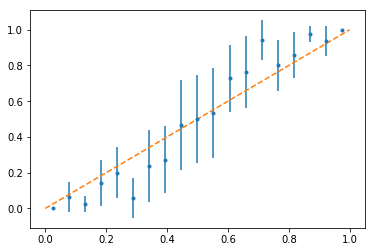

In [21]:
plt.errorbar(midpoints, election_agg['mean'].values, yerr=election_agg['err'].values, fmt='.')
plt.plot([0, 1], [0, 1], '--')

### Question 6: computing the coverage

If our intervals were true 95% confidence intervals, then we would expect about 95% of them to cover the midpoint of the bin (i.e. overlap with the y=x line).  What fraction of the 95% confidence intervals cover the bin midpoint?  Create a list called `upper` to be the `mean` + `err` and another `lower` to be `mean` - `err`.  Next, compute `frac_covering` as the fraction of midpoints between `lower` and `upper`. 

<!--
BEGIN QUESTION
name: q5
manual: false
points: 2
-->

In [22]:
upper = election_agg['err']+election_agg['mean']
lower = election_agg['mean']-election_agg['err']
upper=upper.tolist()
lower=lower.tolist()
total=len(midpoints)
frac_covering= 0
for i in range(0,19):
    if (lower[i]) <= (midpoints[i]) <= (upper[i]):
        frac_covering+=1
frac_covering=frac_covering/total
frac_covering

0.6842105263157895

In [23]:
ok.grade("q6");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q6 > Suite 1 > Case 3

>>> all(lower < upper)
TypeError: 'bool' object is not iterable

# Error: expected
#     True
# but got
#     Traceback (most recent call last):
#       ...
#     TypeError: 'bool' object is not iterable

Run only this test case with "python3 ok -q q6 --suite 1 --case 3"
---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 1
[ooooook....] 66.7% passed



### Question 7: understanding confidence intervals

Are the 95% confidence intervals generally larger or smaller for more confident predictions (e.g. the predictions closer to 0 or 1).  What are the factors that determine the length of the confidence intervals?

The 95% confidence intervals are generally smaller for more confdient predictions. Increasing the confidence level of a confidence interval will result in larger intervals (or at least not smaller). The Sample size, the standard deviation and the the confidence level will affect the length of the confidence interval 

### Question 8: finding the candidate that had the biggest change in support

Let's see if we can find the candidate that seemed to improve their standing the most between  August 11 and November 6.  First, fill in the function `abs_diff`, which takes in a pandas data frame and computes the difference between the largest values of `probwin` and the smallest value.  



In [24]:
# Input: a pandas dataframe with a numeric column named `probwin`
# Output: a pandas dataframe with the same columns, with an additional column named `absdiff`


def abs_diff(x):
    x['abs_diss']=x['probwin'].max()-x['probwin'].min()
    return x

We can use this function to compute the difference between the maximum and minimum predicted with probabilities for every candidate.  To do so, group `election_sub` by `candidate` and `apply` the function `abs_diff`.  Find the index of the largest difference in `diff_dataframe` and store it in `max_idx`.  Do this using `np.nanargmax` function.  This function finds the _index_ of the largest value, ignoring any missing values (`nans`). 

In [25]:
#election_subc=election_sub.groupby("candidate")


In [26]:
#diff=election_subc['probwin'].max()-election_subc['probwin'].min()

In [27]:
diff_dataframe=election_sub.groupby(["candidate"]).apply(abs_diff)
max_idx=np.nanargmax(diff_dataframe['abs_diss'])
max_idx




628

<!--
BEGIN QUESTION
name: q5
manual: false
points: 2
-->

In [28]:
candidate = diff_dataframe.iloc[[628]]
candidate=candidate.candidate.tolist()[0]

In [29]:
ok.grade("q8");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Did the candidate win or lose the election?

The candidate win the election because probwin_outcome is 1.

### Question 9: plot predictions over time

Plot the forecasted win probability for the candidate you found above, for every available date.  For this you'll need to return to working with the full `election_data`, not `election_sub`.  Don't forget, you should still filter to `classic` forecasts only.  First, create an array of `predicted_probs` for the candidate at every date.  Also save the date in an array called `forecast_date`.  When creating `forecast_date`, use `pd.to_datetime` to convert a `str` datatype to the date format that can easily be plotted.

<!--
BEGIN QUESTION
name: q6
manual: false
points: 2
-->

In [30]:
election_sub_c= election_data[(election_data.forecast_type=="classic")]
s=election_sub_c.loc[election_sub_c['candidate'] =='Sharice Davids']
s['forecast_date'] = pd.to_datetime(s['forecast_date'].values)

predicted_probs =s['probwin']
forecast_date =s['forecast_date']
forecast_date

/Users/Eduardo/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1890     2018-11-06
4791     2018-11-05
7692     2018-11-04
10593    2018-11-03
13482    2018-11-02
16368    2018-11-01
19254    2018-10-31
22140    2018-10-30
25026    2018-10-29
27912    2018-10-28
30798    2018-10-27
33684    2018-10-26
36570    2018-10-25
39456    2018-10-24
42342    2018-10-23
45228    2018-10-22
48114    2018-10-21
51000    2018-10-20
53886    2018-10-19
56772    2018-10-18
59658    2018-10-17
62544    2018-10-16
65430    2018-10-15
68316    2018-10-14
71202    2018-10-13
74088    2018-10-12
76974    2018-10-11
79860    2018-10-10
82746    2018-10-09
85632    2018-10-08
            ...    
198078   2018-08-30
200961   2018-08-29
203844   2018-08-28
206727   2018-08-27
209610   2018-08-26
212493   2018-08-25
215376   2018-08-24
218259   2018-08-23
221142   2018-08-22
224025   2018-08-21
226908   2018-08-20
229791   2018-08-19
232674   2018-08-18
235557   2018-08-17
238440   2018-08-16
241323   2018-08-15
244206   2018-08-14
247089   2018-08-13
249972   2018-08-12


/Users/Eduardo/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


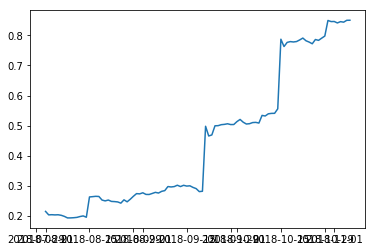

In [31]:
import math
plt.plot(forecast_date.values, predicted_probs)


plt.show()

In [32]:
ok.grade("q9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



Now create a lineplot with forecast date on the x-axis and the predicted win probability on the y-axis.

### Question 10: prediction histograms

Make a histogram showing the predicted win probabilities on the morning of the election.  Again, restrict yourself to only the `classic` predictions.

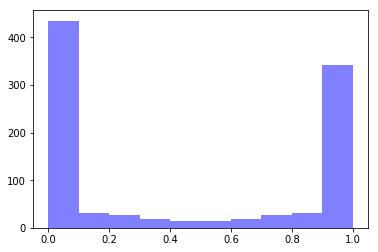

In [33]:

s=election_data[((election_data.forecast_type=="classic") & (election_data.forecast_date=="2018-08-11"))]["probwin"]

n, bins, patches = plt.hist(s, 10, facecolor='blue', alpha=0.5)
plt.show()


Are most house elections easy to forecast or hard to forecast?

The most house elections are easy to forecast. Because the most distribution lie in  0 and 1. 

### Question 11: Comparing election and baseball predictions

Fivethirtyeight also builds predictive models for sporting events.  The following code will down a csv file containg their predictions for who would win every major league baseball game over the past two years.

In [34]:
!wget https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/mlb_games.csv    

--2019-05-21 23:00:34--  https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/mlb_games.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.196.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562029 (549K) [text/plain]
Saving to: ‘mlb_games.csv.3’

mlb_games.csv.3     100%[===================>] 548.86K  1.68MB/s    in 0.3s    

2019-05-21 23:00:35 (1.68 MB/s) - ‘mlb_games.csv.3’ saved [562029/562029]



Create a pandas dataframe from the csv and print the first 10 rows.

In [35]:
baseball = pd.read_csv("mlb_games.csv")
baseball.iloc[0:10]

,season,date,team1,team2,dh,prob1,prob1_outcome,prob2,prob2_outcome
0,2018,2018-10-28,Dodgers,Red Sox,0,0.483877,0.0,0.516123,1.0
1,2018,2018-10-27,Dodgers,Red Sox,0,0.508342,0.0,0.491658,1.0
2,2018,2018-10-26,Dodgers,Red Sox,0,0.555907,1.0,0.444093,0.0
3,2018,2018-10-24,Red Sox,Dodgers,0,0.619808,1.0,0.380192,0.0
4,2018,2018-10-23,Red Sox,Dodgers,0,0.648954,1.0,0.351046,0.0
5,2018,2018-10-20,Brewers,Dodgers,0,0.509500,0.0,0.490500,1.0
6,2018,2018-10-19,Brewers,Dodgers,0,0.505211,1.0,0.494789,0.0
7,2018,2018-10-18,Astros,Red Sox,0,0.603029,0.0,0.396971,1.0
8,2018,2018-10-17,Astros,Red Sox,0,0.568016,0.0,0.431984,1.0
9,2018,2018-10-17,Dodgers,Brewers,0,0.600428,1.0,0.399572,0.0


In this dataframe `prob1` is the predicted win probability for `team1`.  Make a histogram of `prob1`.  Set the limits of the x-axis to `[0, 1]`

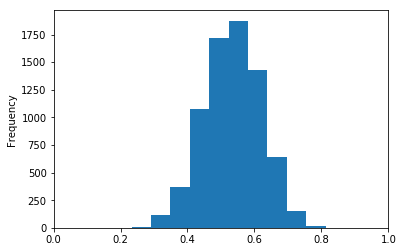

In [36]:
baseball['prob1'].plot.hist(xlim=(0,1)) 

plt.show()


### Question 12

Find the most "surprising" baseball game outcome.  To do so, select all of the entries for which `prob1_outcome` is 1 (i.e. `team1` won the game), and then look for the index of the row containing the smallest value of `prob1`.  This will correspond to the game that was most suprising according to fivethirtyeights predictions. Find and print the row corresponding to this most surprising outcome.

In [37]:
s=baseball[(baseball.prob1_outcome==1)]
np.nanargmin(baseball['prob1'])

s.iloc[1154]


season                 2018
date             2018-04-22
team1               Yankees
team2             Blue Jays
dh                        0
prob1              0.631126
prob1_outcome             1
prob2              0.368874
prob2_outcome             0
Name: 2164, dtype: object

### Question 13
Are the outcomes of baseball games generally easier or harder to predict than the outcomes of political elections?  In a few sentences, comment on why this might be the case.  What data is available for these predictions? What factors affect the outcomes of elections and baseball games? What makes an event like an election or a baseballgame "random"?

*Write your answer here, replacing this text.*

The outcomes of baseball games is harder to predict than the outcomes of political election.
Because according to the histogram the baseball games plot shows there is a peak in the middle, but in the election graph, there are 2 peaks in 0, 1. The distribution of baseball game is more random and the distribution of the election is more confidence.  The data is available in MLA  baseball game and election data from US_election_dataThe factor may affect the outcomes of election is news, and for the baseball game can be weather, and member's health condition. The baseball gan have more unconfidence factor to affectthe predictions.  

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

In [38]:
# Save your notebook first, then run this cell to submit.
# Removed by AutoGrader# Removed by AutoGraderok.submit()